In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Load in the data

In [2]:
df = pd.read_csv('complaints_cleaned_comb.csv')
df = df.sample(n=4673)
df.head()

,Product,Consumer_complaint_narrative,Category_ID
250837,Mortgage,My wife and I applied for a refinance mortgage...,7
419510,"Credit reporting, credit repair services, or o...",On XXXX XXXX an electronic payment was made to...,4
545383,"Credit reporting, credit repair services, or o...",I recently disputed the accounts with both XXX...,4
386644,"Credit reporting, credit repair services, or o...","I have fraudulent accounts thats not mines, Iv...",4
317452,"Credit reporting, credit repair services, or o...",section 609 of the fcra states that there must...,4


Create a dataframe and dictionary necessary for the term-product correlation code.

In [3]:
category_id_df = df[['Product', 'Category_ID']].drop_duplicates().sort_values('Category_ID')
category_to_id = dict(category_id_df.values)

# Visualize the Consumer Complaint counts

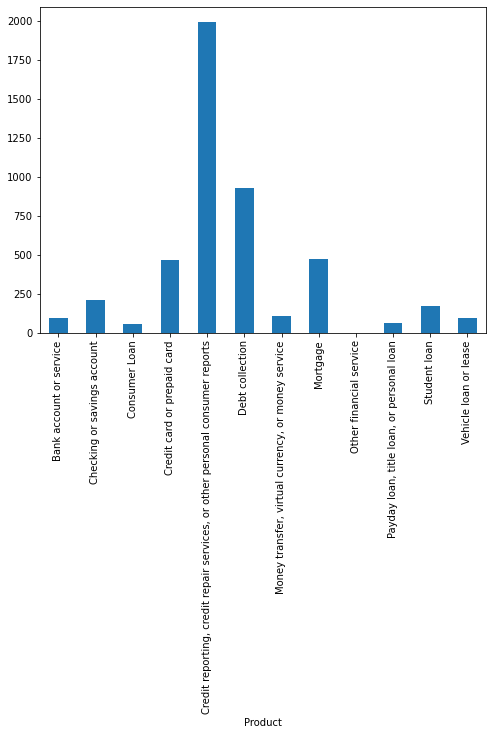

Credit reporting, credit repair services, or other personal consumer reports    1992
Debt collection                                                                  928
Mortgage                                                                         474
Credit card or prepaid card                                                      468
Checking or savings account                                                      213
Student loan                                                                     172
Money transfer, virtual currency, or money service                               106
Bank account or service                                                           98
Vehicle loan or lease                                                             96
Payday loan, title loan, or personal loan                                         66
Consumer Loan                                                                     59
Other financial service                                          

In [4]:
# plot frequencies
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

df.Product.value_counts()

We're seeing lots of bias towards credit reporting, debt collection, and mortgage. We can fix this with resampling via SMOTE etc., but we want the algorithm to have high accuracy in predicting the majority classes while maintaining decent accuracy in predicting the minority classes. Thus, we'll leave the training data as it is.

# Start using Consumer Complaint Narratives to determine keywords

Convert Consumer Complaint Narratives to TF-IDF features.

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.Category_ID
features.shape

(4673, 14475)

Feed the TF-IDF features into feature_selection.chi2 so we can determine and print the words/phrases in the Consumer Complaint Narratives that are highly correlated with Products.

In [6]:
# iterate through the different products and print their most correlated unigrams and bigrams
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])    # indices of sorted features_chi2 array
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-2:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-2:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . noise
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . 00 overdraft
# 'Checking or savings account':
  . Most correlated unigrams:
       . deposit
       . checking
  . Most correlated bigrams:
       . debit card
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . inconsistencies
       . toyota
  . Most correlated bigrams:
       . xxxx ally
       . financial xxxx
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . amex
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
       . report
       . equifax
  . Most correlated bigrams:
       . credit file
       . credit report
# 'Debt collection':
  . Most correlated unigrams:
       . collection
       . debt
  . Most correlated bigrams